In [1]:
# Librerías base
import numpy as np
import pandas as pd
import time
from scipy.stats import loguniform

# Visualización 
import matplotlib.pyplot as plt

# Sklearn
from sklearn.model_selection import train_test_split, StratifiedKFold, GridSearchCV, RandomizedSearchCV
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder, StandardScaler, Binarizer
from sklearn.impute import SimpleImputer

# Modelos
from sklearn.naive_bayes import GaussianNB, BernoulliNB
from sklearn.svm import SVC, LinearSVC
from sklearn.calibration import CalibratedClassifierCV

# Métricas y curvas
from sklearn.metrics import (
    roc_curve, precision_recall_curve
)

from utils import *

In [2]:
df = pd.read_csv("data-churn.csv")

df["Churn"] = df["Churn"].map({"Yes": 1, "No": 0})

target = "Churn"

X = df.drop(columns=[target]).copy()
y = df[target].copy()

numeric_features = X.select_dtypes(include=[np.number]).columns.tolist()
categorical_features = X.select_dtypes(exclude=[np.number]).columns.tolist()

print("Shape:", df.shape)
print("Target distribution:\n", y.value_counts(normalize=True))

Shape: (7043, 21)
Target distribution:
 Churn
0    0.73463
1    0.26537
Name: proportion, dtype: float64


In [3]:
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

In [5]:
ohe_dense = OneHotEncoder(handle_unknown="ignore", sparse_output=False)

numeric_transformer_nb = Pipeline(steps=[
    ("imputer", SimpleImputer(strategy="median")),
    ("scaler", StandardScaler())
])

categorical_transformer_nb = Pipeline(steps=[
    ("imputer", SimpleImputer(strategy="most_frequent")),
    ("onehot", ohe_dense)
])

preprocessor_nb = ColumnTransformer(
    transformers=[
        ("num", numeric_transformer_nb, numeric_features),
        ("cat", categorical_transformer_nb, categorical_features),
    ],
    remainder="drop"
)

pipe_nb = Pipeline(steps=[
    ("preprocessor", preprocessor_nb),
    ("clf", GaussianNB())  
])

In [6]:
param_grid_nb = [
    {
        "clf": [GaussianNB()],
        "clf__var_smoothing": np.logspace(-12, -7, 6)
    },
    {
        "clf": [BernoulliNB()],
        "clf__alpha": [0.1, 0.5, 1.0, 2.0, 5.0],
        "clf__binarize": [0.0, 0.5, 1.0]
    }
]

scoring_main = "f1"  # o "average_precision"

cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

t0 = time.perf_counter()
grid_nb = GridSearchCV(
    estimator=pipe_nb,
    param_grid=param_grid_nb,
    scoring=scoring_main,
    cv=cv,
    n_jobs=-1,
    verbose=0
)
grid_nb.fit(X_train, y_train)
t_nb = time.perf_counter() - t0


In [7]:
print("=== Naïve Bayes ===")
print("Best params:", grid_nb.best_params_)
print(f"CV best {scoring_main}: {grid_nb.best_score_:.4f}")
print(f"GridSearch time (s): {t_nb:.2f}")

best_nb = grid_nb.best_estimator_

=== Naïve Bayes ===
Best params: {'clf': BernoulliNB(), 'clf__alpha': 0.5, 'clf__binarize': 0.5}
CV best f1: 0.6200
GridSearch time (s): 138.46


model        NaiveBayes
accuracy       0.755855
precision      0.530242
recall         0.703209
f1             0.604598
auc_roc        0.807372
pr_auc         0.588491
dtype: object


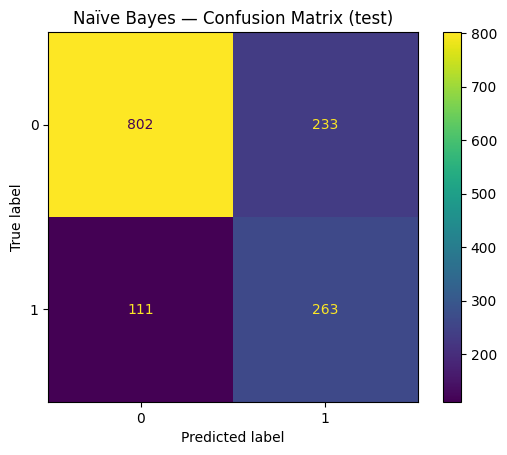

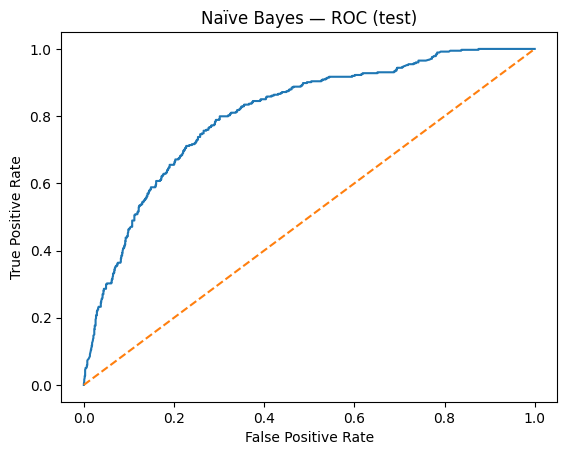

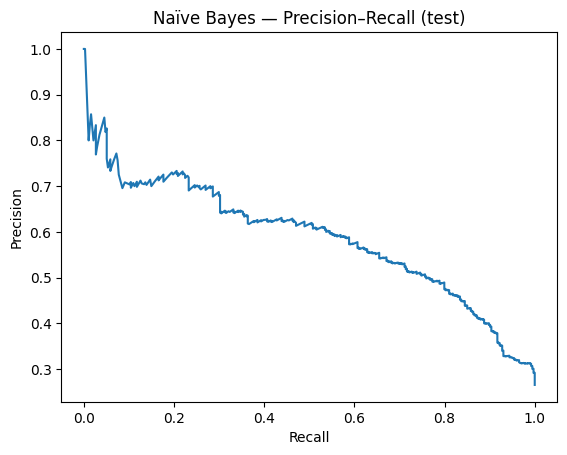

In [8]:
nb_metrics, nb_pred, nb_score = report_test_metrics(best_nb, X_test, y_test, label="NaiveBayes")
print(pd.Series(nb_metrics))

plot_confusion(y_test, nb_pred, title="Naïve Bayes — Confusion Matrix (test)")

fpr, tpr, _ = roc_curve(y_test, nb_score)
prec, rec, _ = precision_recall_curve(y_test, nb_score)

fig, ax = plt.subplots()
ax.plot(fpr, tpr)
ax.plot([0, 1], [0, 1], linestyle="--")
ax.set_title("Naïve Bayes — ROC (test)")
ax.set_xlabel("False Positive Rate")
ax.set_ylabel("True Positive Rate")
plt.show()

fig, ax = plt.subplots()
ax.plot(rec, prec)
ax.set_title("Naïve Bayes — Precision–Recall (test)")
ax.set_xlabel("Recall")
ax.set_ylabel("Precision")
plt.show()

Se evaluaron dos variantes de Naïve Bayes: GaussianNB y BernoulliNB.
GaussianNB es adecuado cuando las variables numéricas (tras escalamiento) pueden aproximarse a distribuciones normales.
BernoulliNB se adapta mejor a variables binarias, como las generadas por one-hot encoding, y puede ser útil si las variables numéricas se binarizan.
La selección final se realiza mediante validación cruzada comparando desempeño en F1-score.

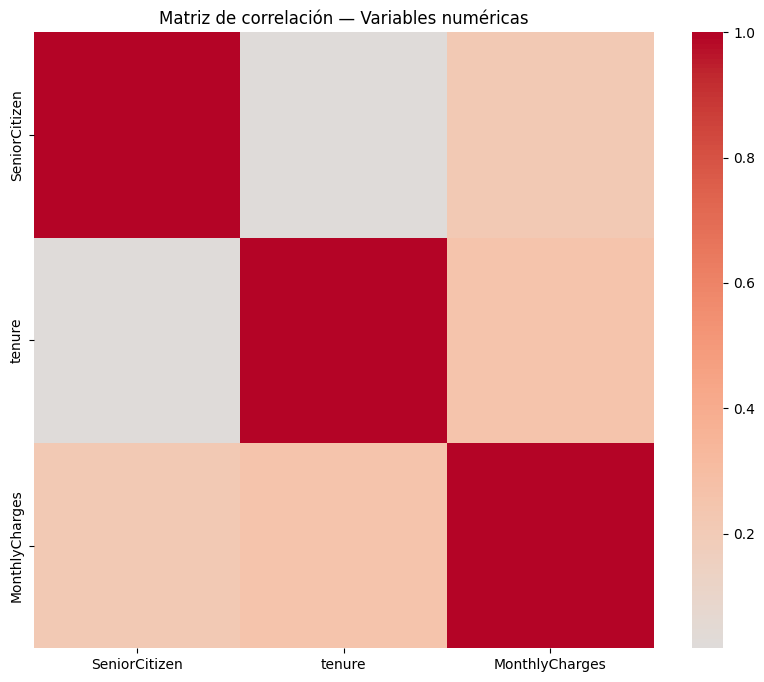

In [12]:
import seaborn as sns
import matplotlib.pyplot as plt

# Solo variables numéricas
corr_matrix = X_train[numeric_features].corr()

plt.figure(figsize=(10,8))
sns.heatmap(corr_matrix, cmap="coolwarm", center=0)
plt.title("Matriz de correlación — Variables numéricas")
plt.show()


La matriz de correlación entre las variables numéricas muestra que no existe independencia total entre los predictores. Se observa una correlación positiva moderada entre tenure y MonthlyCharges, lo que indica que clientes con mayor antigüedad tienden a tener cargos mensuales distintos a los de clientes nuevos.

Aunque las correlaciones no son extremadamente altas, esta dependencia viola el supuesto de independencia condicional de Naïve Bayes. Esto puede afectar la estimación de probabilidades, ya que el modelo puede sobreestimar la evidencia cuando varias variables contienen información similar.

In [9]:
ohe_sparse = OneHotEncoder(handle_unknown="ignore")  

numeric_transformer_svm = Pipeline(steps=[
    ("imputer", SimpleImputer(strategy="median")),
    ("scaler", StandardScaler())
])

categorical_transformer_svm = Pipeline(steps=[
    ("imputer", SimpleImputer(strategy="most_frequent")),
    ("onehot", ohe_sparse)
])

preprocessor_svm = ColumnTransformer(
    transformers=[
        ("num", numeric_transformer_svm, numeric_features),
        ("cat", categorical_transformer_svm, categorical_features),
    ],
    remainder="drop"
)

In [10]:
pipe_linsvm = Pipeline(steps=[
    ("preprocessor", preprocessor_svm),
    ("clf", CalibratedClassifierCV(
        estimator=LinearSVC(dual=True, max_iter=20000),
        method="sigmoid",
        cv=3
    ))
])

param_grid_linsvm = {
    "clf__estimator__C": [0.01, 0.1, 1.0, 10.0, 100.0]
}

pipe_rbf = Pipeline(steps=[
    ("preprocessor", preprocessor_svm),
    ("clf", SVC(kernel="rbf", probability=False))
])

param_grid_rbf = {
    "clf__C": [0.1, 1.0, 10.0, 100.0],
    "clf__gamma": ["scale", "auto", 1e-3, 1e-2, 1e-1]
}

scoring_main = "f1"  # o "average_precision"

In [11]:
print("\n=== SVM Lineal (Grid) ===")
grid_linsvm = GridSearchCV(pipe_linsvm, param_grid_linsvm, scoring=scoring_main, cv=cv, n_jobs=-1)
grid_linsvm, t_grid_lin = timed_search(grid_linsvm, X_train, y_train, label="Grid LinearSVM")

print("\n=== SVM RBF (Grid) ===")
grid_rbf = GridSearchCV(pipe_rbf, param_grid_rbf, scoring=scoring_main, cv=cv, n_jobs=-1)
grid_rbf, t_grid_rbf = timed_search(grid_rbf, X_train, y_train, label="Grid RBF-SVM")

print("\n=== SVM Lineal (Random) ===")
rand_linsvm = RandomizedSearchCV(
    pipe_linsvm,
    param_distributions={"clf__estimator__C": loguniform(1e-3, 1e2)},
    n_iter=20,
    scoring=scoring_main,
    cv=cv,
    n_jobs=-1,
    random_state=42
)
rand_linsvm, t_rand_lin = timed_search(rand_linsvm, X_train, y_train, label="Random LinearSVM")

print("\n=== SVM RBF (Random) ===")
rand_rbf = RandomizedSearchCV(
    pipe_rbf,
    param_distributions={"clf__C": loguniform(1e-2, 1e3), "clf__gamma": loguniform(1e-4, 1e0)},
    n_iter=30,
    scoring=scoring_main,
    cv=cv,
    n_jobs=-1,
    random_state=42
)
rand_rbf, t_rand_rbf = timed_search(rand_rbf, X_train, y_train, label="Random RBF-SVM")

# Elegimos el mejor (según score CV) para cada familia
best_lin = grid_linsvm.best_estimator_ if grid_linsvm.best_score_ >= rand_linsvm.best_score_ else rand_linsvm.best_estimator_
best_rbf = grid_rbf.best_estimator_ if grid_rbf.best_score_ >= rand_rbf.best_score_ else rand_rbf.best_estimator_

# ---- Reporte final en test (métricas, curvas) :contentReference[oaicite:12]{index=12}
lin_metrics, lin_pred, lin_score = report_test_metrics(best_lin, X_test, y_test, label="SVM Linear (best)")
rbf_metrics, rbf_pred, rbf_score = report_test_metrics(best_rbf, X_test, y_test, label="SVM RBF (best)")

results = pd.DataFrame([nb_metrics, lin_metrics, rbf_metrics]).set_index("model")


=== SVM Lineal (Grid) ===
Grid LinearSVM best roc_auc: 0.5918 | time(s)=13.75

=== SVM RBF (Grid) ===
Grid RBF-SVM best roc_auc: 0.5931 | time(s)=88.08

=== SVM Lineal (Random) ===
Random LinearSVM best roc_auc: 0.5918 | time(s)=5.90

=== SVM RBF (Random) ===
Random RBF-SVM best roc_auc: 0.6053 | time(s)=109.19



=== Test metrics summary ===


,accuracy,precision,recall,f1,auc_roc,pr_auc
model,,,,,,
NaiveBayes,0.755855,0.530242,0.703209,0.604598,0.807372,0.588491
SVM Linear (best),0.795600,0.644295,0.513369,0.571429,0.838286,0.634770
SVM RBF (best),0.772179,0.563855,0.625668,0.593156,0.825596,0.601856


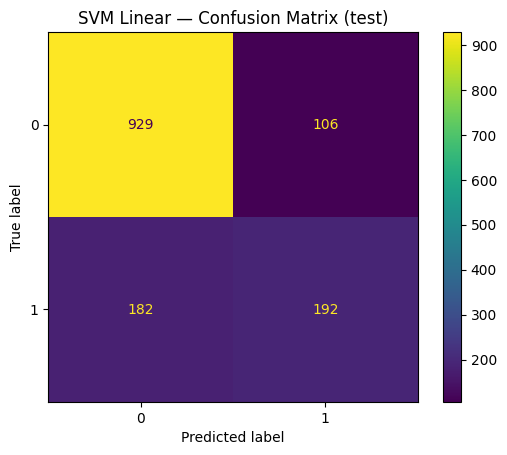

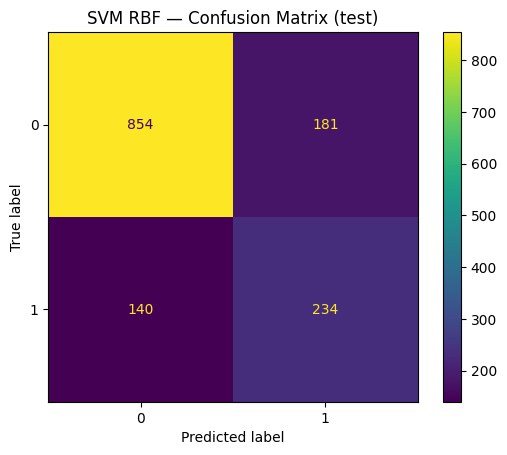

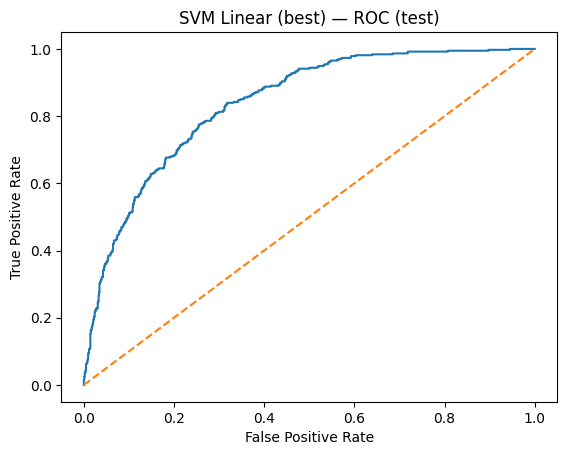

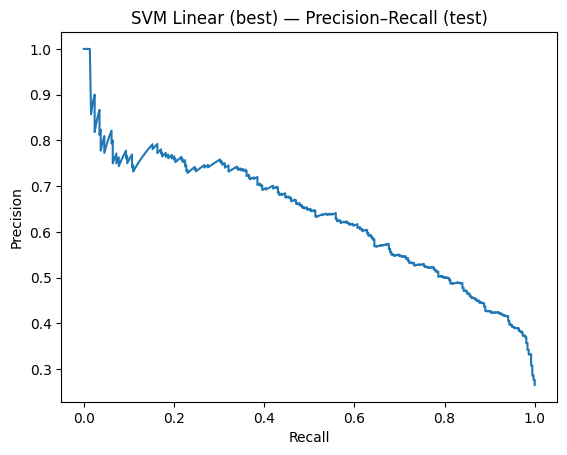

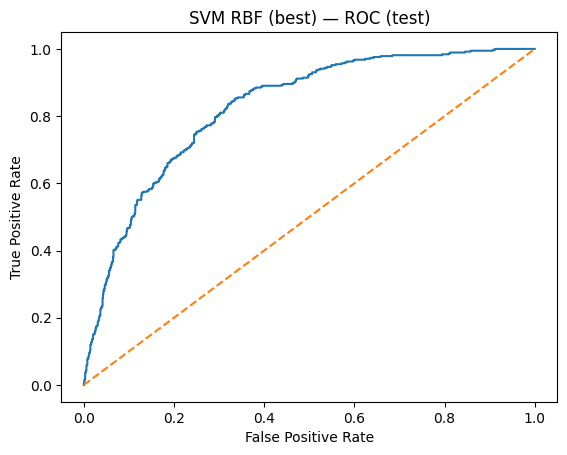

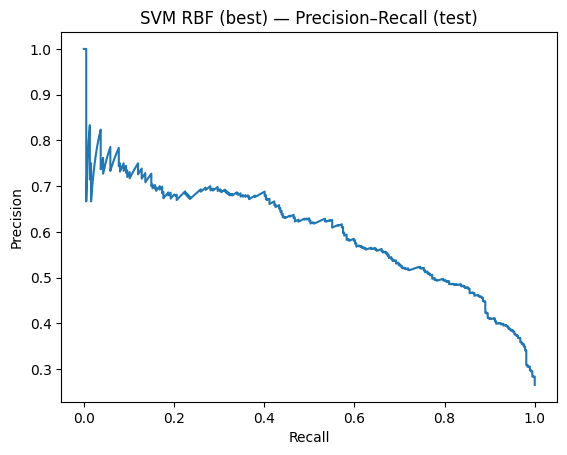

In [13]:
print("\n=== Test metrics summary ===")
display(results)

plot_confusion(y_test, lin_pred, title="SVM Linear — Confusion Matrix (test)")
plot_confusion(y_test, rbf_pred, title="SVM RBF — Confusion Matrix (test)")

# Curvas ROC/PR en test


plot_roc_pr(y_test, lin_score, title="SVM Linear (best)")
plot_roc_pr(y_test, rbf_score, title="SVM RBF (best)")

# ============================================================
# 2e) Desbalance: repetir mejor SVM con class_weight='balanced' :contentReference[oaicite:13]{index=13}
# ============================================================

# Reentrena SOLO la mejor familia (ejemplo: RBF). Puedes hacerlo para ambos si quieres.
best_rbf_balanced = Pipeline(steps=[
    ("preprocessor", preprocessor_svm),
    ("clf", SVC(kernel="rbf", class_weight="balanced"))
])


=== SVM RBF balanced (test) ===
model        SVM RBF balanced
accuracy             0.772179
precision            0.563855
recall               0.625668
f1                   0.593156
auc_roc              0.825596
pr_auc               0.601856
dtype: object


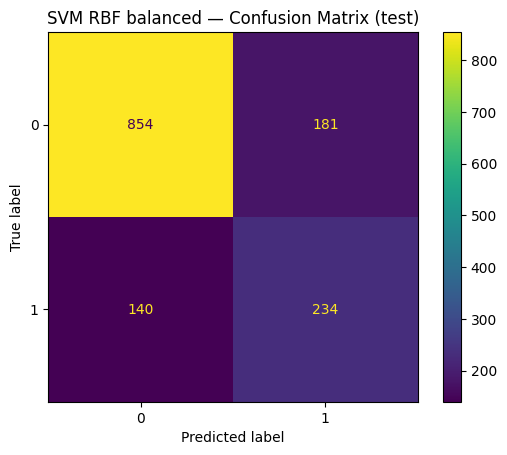

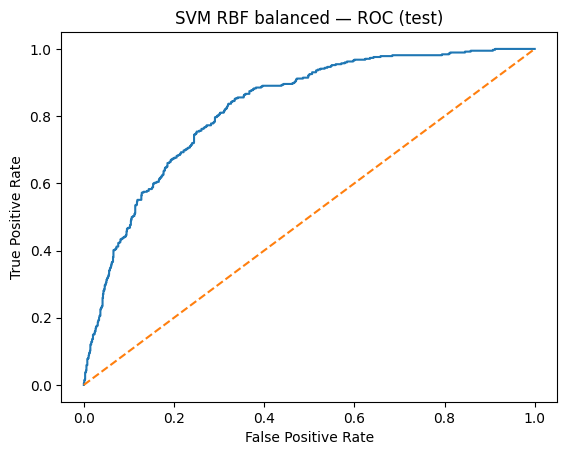

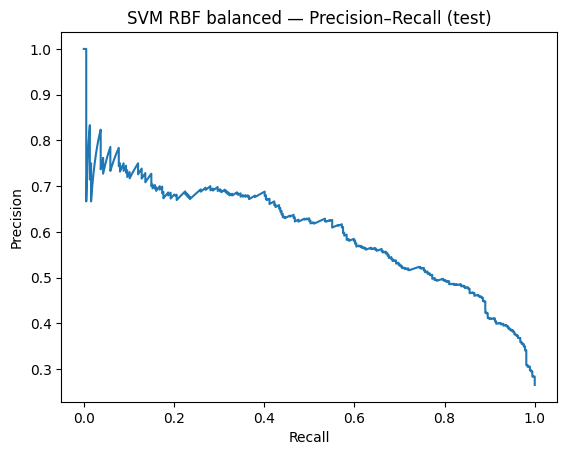

In [14]:
# Usamos los mejores hiperparámetros encontrados
best_params = {}
if hasattr(best_rbf, "get_params"):
    bp = best_rbf.get_params()
    # Extraemos C y gamma si venían
    if "clf__C" in bp: best_params["clf__C"] = bp["clf__C"]
    if "clf__gamma" in bp: best_params["clf__gamma"] = bp["clf__gamma"]

best_rbf_balanced.set_params(**best_params)
best_rbf_balanced.fit(X_train, y_train)

rbf_bal_metrics, rbf_bal_pred, rbf_bal_score = report_test_metrics(
    best_rbf_balanced, X_test, y_test, label="SVM RBF balanced"
)

print("\n=== SVM RBF balanced (test) ===")
print(pd.Series(rbf_bal_metrics))
plot_confusion(y_test, rbf_bal_pred, title="SVM RBF balanced — Confusion Matrix (test)")
plot_roc_pr(y_test, rbf_bal_score, title="SVM RBF balanced")